# Loading Libraries

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os     
import matplotlib.pyplot as plt
import seaborn as sns 
#import lightgbm as lgb
#from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# Extracting Features from train set

In [3]:
gc.enable()

train = pd.read_csv('../data/training_set.csv')
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']

agg_db = pd.DataFrame([])#,columns='object_id')
agg_db['object_id'] = train['object_id'].unique()

#agg_db = pd.DataFrame(data=agg_db['object_id'].unique(),columns='object_id')
for pband in sorted(train['passband'].unique()):
    print("Looking at passband " + str(pband))
    pband_data = train.loc[train['passband'] == pband]
    for col in pband_data.columns:
        if col != 'object_id':
            pband_data[col + str(pband)] = pband_data[col]
            del pband_data[col]
    #pband_data['passband # '+ str(pband)] = pband_data['passband']
   # del pband_data['passband']

    aggs = {
        'mjd'+ str(pband): ['min', 'max', 'size'],
        #'passband' + str(pband): ['min', 'max', 'mean', 'median', 'std'],
        'flux'+ str(pband): ['min', 'max', 'mean', 'median', 'std','skew'],
        'flux_err'+ str(pband): ['min', 'max', 'mean', 'median', 'std','skew'],
        'detected'+ str(pband): ['mean'],
        'flux_ratio_sq'+ str(pband):['sum','skew'],
        'flux_by_flux_ratio_sq'+ str(pband):['sum','skew'],
    }


    agg_train = pband_data.groupby('object_id').agg(aggs)
    new_columns = [
        k + '_' + agg for k in aggs.keys() for agg in aggs[k]
    ]
    agg_train.columns = new_columns

    agg_train['mjd_diff'+str(pband)] = agg_train['mjd'+ str(pband)+'_max'] - agg_train['mjd'+ str(pband)+'_min']
    agg_train['flux_diff'+str(pband)] = agg_train['flux'+ str(pband)+'_max'] - agg_train['flux'+ str(pband)+'_min']
    agg_train['flux_dif2'+str(pband)] = (agg_train['flux'+ str(pband)+'_max'] - agg_train['flux'+ str(pband)+'_min']) / agg_train['flux'+ str(pband)+'_mean']
    agg_train['flux_w_mean'+str(pband)] = agg_train['flux_by_flux_ratio_sq' +str(pband)+'_sum'] / agg_train['flux_ratio_sq' +str(pband)  + '_sum']
    agg_train['flux_dif3'+str(pband)] = (agg_train['flux'+str(pband) + '_max'] - agg_train['flux'+ str(pband) +'_min']) / agg_train['flux_w_mean'+str(pband)]

    del agg_train['mjd'+str(pband)  +'_max'], agg_train['mjd'+str(pband)  +'_min']
    #agg_train.head()
    
   # del agg_train['passband']
    
    agg_db = pd.merge(left=agg_db,right=agg_train,on='object_id')
    
    #result = pd.concat([df1, df4], axis=1, sort=False)
    
del train
gc.collect()






Looking at passband 0


/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Looking at passband 1
Looking at passband 2
Looking at passband 3
Looking at passband 4
Looking at passband 5


140

# Merging extracted features with meta data

In [4]:
meta_train = pd.read_csv('../data/training_set_metadata.csv')
meta_train.head()



full_train = agg_db.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [5]:
if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']
    
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

del full_train['index']

In [6]:
full_train.shape

(7848, 141)

So this model will have 7848 sources to train/test on, and using 141 unique features for each. 

# Standard Scaling the input (imp.)

In [7]:
full_train_new = full_train.copy()
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train_new)

# Deep Learning Begins...

In [8]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [9]:
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [10]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

# Defining simple model in keras

Note this is the same as the one used in the original kernel, I don't feel confident enough to change the # of neurons and so on. 

In [11]:
K.clear_session()
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model

In [12]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

# Calculating the class weights

In [13]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [14]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

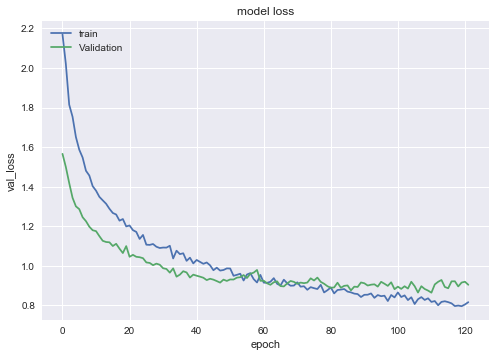

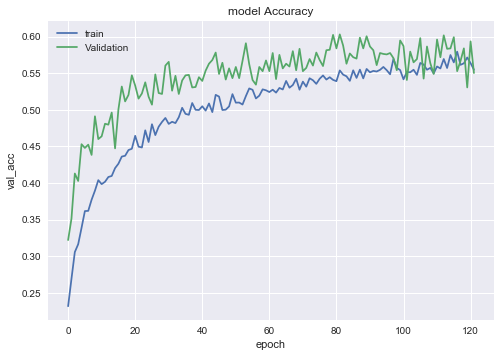

Loading Best Model
0.87255461668


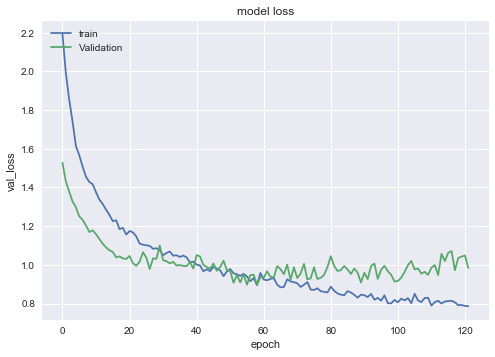

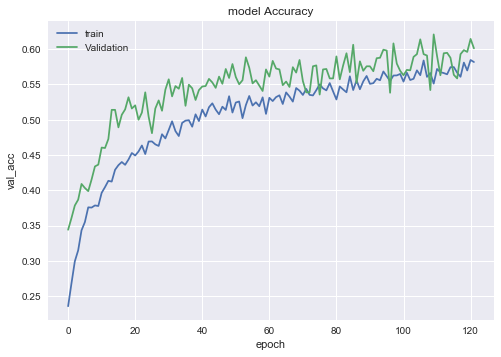

Loading Best Model
0.87807322335


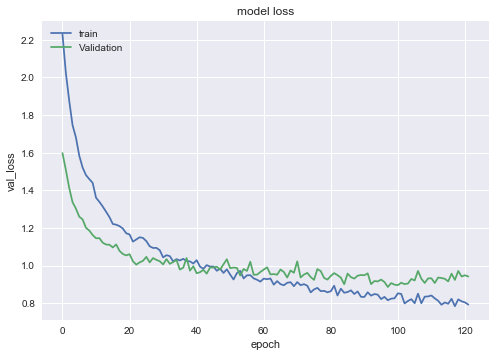

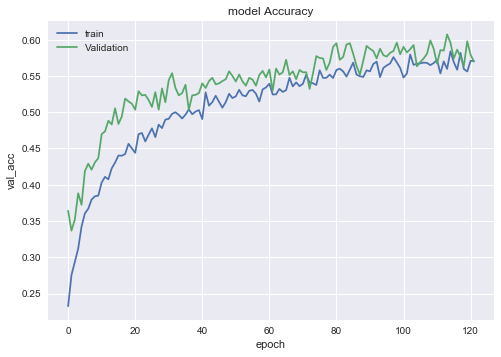

Loading Best Model
0.913176850495


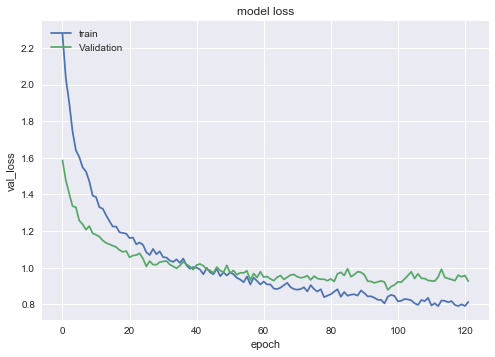

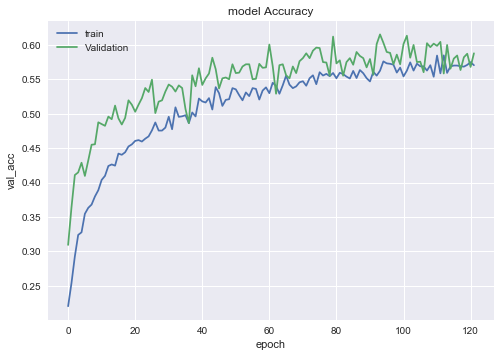

Loading Best Model
0.91977191598


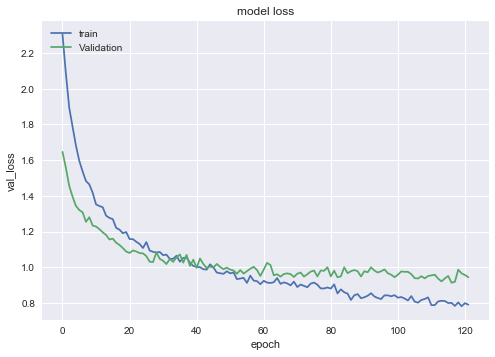

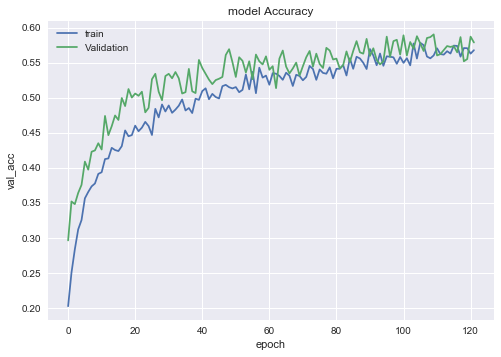

Loading Best Model
0.944459741025
MULTI WEIGHTED LOG LOSS : 0.90488 


In [15]:
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 123
batch_size = 100
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.5,activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

As I mentioned earlier the test set performs far worse than this one. There are many things to blame for this, but primarily things to consider are the frequency of different object classifications that may exist in the test set (and thus changing the metric used as the weights will be different). Another source is the means for creating a prediction for that 15th class, which could be done a number of ways as described in the challenge handbook. Due to time constraints and computational cost, this is all I have for now. 

In [16]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [17]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [21]:
sample_sub = pd.read_csv('../data/sample_submission_format.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

34905

Normalized confusion matrix
[[  8.48e-01   0.00e+00   1.99e-02   6.62e-03   0.00e+00   6.62e-03
    0.00e+00   3.31e-02   7.28e-02   6.62e-03   0.00e+00   0.00e+00
    6.62e-03   0.00e+00]
 [  1.01e-02   6.95e-01   0.00e+00   3.23e-02   3.84e-02   0.00e+00
    5.86e-02   3.64e-02   1.01e-02   3.84e-02   2.02e-02   4.24e-02
    0.00e+00   1.82e-02]
 [  3.25e-03   0.00e+00   9.68e-01   0.00e+00   0.00e+00   0.00e+00
    0.00e+00   2.16e-03   9.74e-03   0.00e+00   1.08e-03   0.00e+00
    1.62e-02   0.00e+00]
 [  6.71e-03   1.17e-01   8.38e-04   1.94e-01   1.77e-01   0.00e+00
    1.37e-01   4.27e-02   1.42e-02   1.37e-01   1.68e-03   1.32e-01
    8.38e-04   4.02e-02]
 [  5.46e-03   6.56e-02   0.00e+00   6.56e-02   3.55e-01   0.00e+00
    8.74e-02   3.83e-02   5.46e-03   1.64e-01   0.00e+00   1.91e-01
    0.00e+00   2.19e-02]
 [  3.33e-02   0.00e+00   0.00e+00   0.00e+00   0.00e+00   9.67e-01
    0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00
    0.00e+00   0.00e+00]
 [  2.

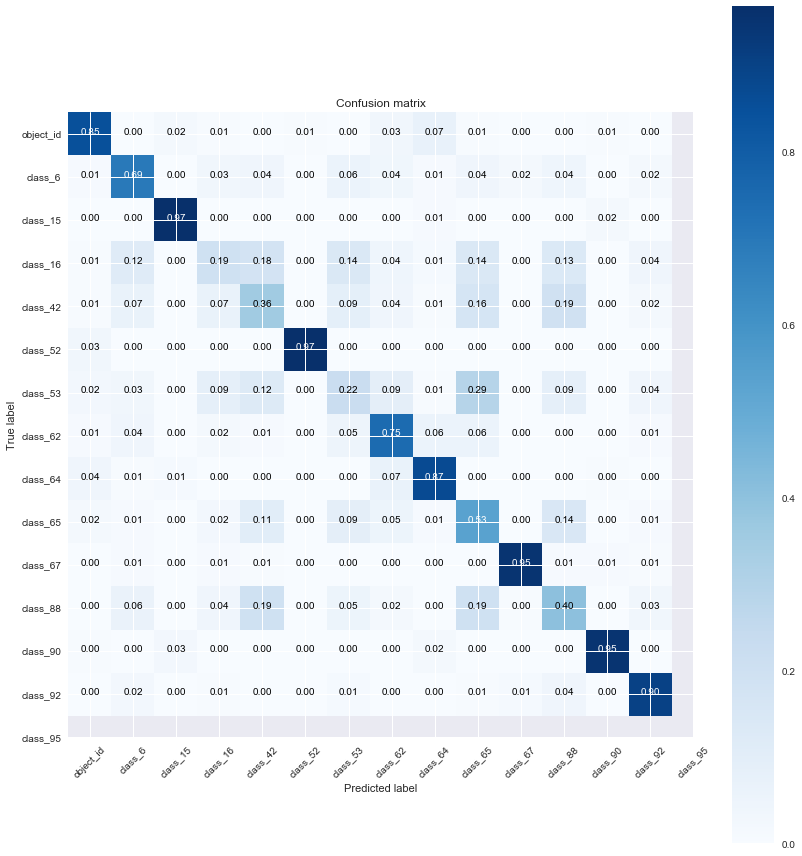

In [24]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')


# Test Set Predictions

This will not be done here!! Too much for my computer to handle. 

In [ ]:

meta_test = pd.read_csv('../input/test_set_metadata.csv')

import time

start = time.time()
chunks = 5000000
for i_c, df in enumerate(pd.read_csv('../input/test_set.csv', chunksize=chunks, iterator=True)):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    agg_db = pd.DataFrame([])#,columns='object_id')
    agg_db['object_id'] = df['object_id'].unique()

#agg_db = pd.DataFrame(data=agg_db['object_id'].unique(),columns='object_id')
    for pband in df['passband'].unique():
      #  print("Looking at passband " + str(pband))
        pband_data = df.loc[df['passband'] == pband]
        for col in pband_data.columns:
            if col != 'object_id':
                pband_data[col + str(pband)] = pband_data[col]
                del pband_data[col]
    #pband_data['passband # '+ str(pband)] = pband_data['passband']
   # del pband_data['passband']

        aggs = {
            'mjd'+ str(pband): ['min', 'max', 'size'],
            #'passband' + str(pband): ['min', 'max', 'mean', 'median', 'std'],
            'flux'+ str(pband): ['min', 'max', 'mean', 'median', 'std','skew'],
            'flux_err'+ str(pband): ['min', 'max', 'mean', 'median', 'std','skew'],
            'detected'+ str(pband): ['mean'],
            'flux_ratio_sq'+ str(pband):['sum','skew'],
            'flux_by_flux_ratio_sq'+ str(pband):['sum','skew'],
        }


        agg_test = pband_data.groupby('object_id').agg(aggs)
        new_columns = [
            k + '_' + agg for k in aggs.keys() for agg in aggs[k]
        ]
        agg_test.columns = new_columns

        agg_test['mjd_diff'+str(pband)] = agg_test['mjd'+ str(pband)+'_max'] - agg_test['mjd'+ str(pband)+'_min']
        agg_test['flux_diff'+str(pband)] = agg_test['flux'+ str(pband)+'_max'] - agg_test['flux'+ str(pband)+'_min']
        agg_test['flux_dif2'+str(pband)] = (agg_test['flux'+ str(pband)+'_max'] - agg_test['flux'+ str(pband)+'_min']) / agg_test['flux'+ str(pband)+'_mean']
        agg_test['flux_w_mean'+str(pband)] = agg_test['flux_by_flux_ratio_sq' +str(pband)+'_sum'] / agg_test['flux_ratio_sq' +str(pband)  + '_sum']
        agg_test['flux_dif3'+str(pband)] = (agg_test['flux'+str(pband) + '_max'] - agg_test['flux'+ str(pband) +'_min']) / agg_test['flux_w_mean'+str(pband)]

        del agg_test['mjd'+str(pband)  +'_max'], agg_test['mjd'+str(pband)  +'_min']
#     del df
#     gc.collect()
    
        agg_db = pd.merge(left=agg_db,right=agg_test,on='object_id')

    
    # Merge with meta data
    full_test = agg_db.reset_index().merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    full_test[full_train.columns] = full_test[full_train.columns].fillna(train_mean)
    full_test_ss = ss.transform(full_test[full_train.columns])
    # Make predictions
    preds = None
    for clf in clfs:
        if preds is None:
            preds = clf.predict_proba(full_test_ss) / folds.n_splits
        else:
            preds += clf.predict_proba(full_test_ss) / folds.n_splits
    
   # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds.shape[0])
    for i in range(preds.shape[1]):
        preds_99 *= (1 - preds[:, i])
    
    # Store predictions
    preds_df = pd.DataFrame(preds, columns=class_names)
    preds_df['object_id'] = full_test['object_id']
    preds_df['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    
    if i_c == 0:
        preds_df.to_csv('predictions.csv',  header=True, mode='a', index=False)
    else: 
        preds_df.to_csv('predictions.csv',  header=False, mode='a', index=False)
        
    del agg_test, full_test, preds_df, preds
#     print('done')
    if (i_c + 1) % 10 == 0:
        print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))

In [ ]:
z = pd.read_csv('predictions.csv')

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z.to_csv('single_predictions.csv', index=True)

In [ ]:
z.head()